In [1]:
import cv2
import os
import time
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Flatten, ConvLSTM2D, Reshape, BatchNormalization, Input, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import load_model, Model
from concurrent.futures import ThreadPoolExecutor
from seq_generator_v2 import FrameGeneratorAffWildPoolV2

2024-06-27 15:50:28.075867: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 15:50:28.128752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 15:50:28.128789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 15:50:28.130603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 15:50:28.139398: I tensorflow/core/platform/cpu_feature_guar

# Constants

In [2]:
ruta_labels_train = '/home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Train_Set'
ruta_labels_validation = '/home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Validation_Set'
ruta_imagenes = '/home/jupyter/tpp/datasets/unprocessed/cropped_aligned'
videos_train = ['325', '326', '327']
videos_validation = ['135', '136']

In [18]:
emociones = ['Negative', 'Positive']
IMG_SIZE = 112
IMG_CHANNELS = 3
MAX_SEQ_LENGTH = 10
NUM_FEATURES = 1024
EPOCHS = 50
BATCH_SIZE= 512

# Load CNN model

In [4]:
from keras.models import model_from_json, Sequential, load_model
from keras.src.saving import serialization_lib


serialization_lib.enable_unsafe_deserialization()

MODELS_PATH = "../Modelos/"
cnn_model_name = "cotatest_v2_binary.keras"

In [5]:
def load_modal_json():
    with open(MODELS_PATH + cnn_model_name + '.json','r') as f:
        json = f.read()
    cnn_model = model_from_json(json)

    cnn_model.load_weights(MODELS_PATH + cnn_model_name + '.h5')
    print(f"Loaded model {cnn_model_name} from disk")
    return cnn_model

In [6]:
def load_model_keras():
    model = load_model(MODELS_PATH + cnn_model_name)
    return model

In [7]:
cnn_model = load_model_keras()

2024-06-27 15:50:39.362882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [9]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 lambda (Lambda)             (None, 112, 112, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [10]:
model = Sequential()
for layer in cnn_model.layers[:-1]: # go through until last layer
    model.add(layer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 lambda (Lambda)             (None, 112, 112, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                        

In [11]:
image = plt.imread('/home/jupyter/tpp/datasets/processed/merge_data/Anger/affwild_pr_9-15-1920x1080_28357.jpg')

image = np.expand_dims(image, axis=0)
image.shape

(1, 112, 112, 3)

In [12]:
result = model.predict(image)

2024-06-27 15:53:56.851429: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


1/1 [==============================] - 4s 4s/step


In [13]:
result[0][450:470]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

# Data Generator

In [19]:
def getFrameGeneratorTrain():
    return FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_train, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=videos_train, verbose=True, binary_mode=True)

fg = getFrameGeneratorTrain()
result = fg()

Generator for videos ['325', '326', '327']
Binary mode ON!


  0%|          | 0/3 [00:00<?, ?it/s]

Processing video 326
Processing video 325
Processing video 327


In [20]:
def getFrameGeneratorValidation():
    return FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=videos_validation, verbose=True, binary_mode=True)

fg = getFrameGeneratorValidation()


Generator for videos ['135', '136']
Binary mode ON!


# Sequence model

In [37]:
base_learning_rate = 0.0001

In [35]:
# Utility for our sequence model.
def get_sequence_model_att():
    frame_features_input = Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = Input((MAX_SEQ_LENGTH), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    lstm = LSTM(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    # Bahdanau Attention layer
    attention_layer = AdditiveAttention()
    context_vector = attention_layer([lstm, lstm])

    #x = LSTM(8, return_sequences=True)(x)
    #x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(context_vector)
    output = TimeDistributed(Dense(len(emociones), activation="softmax"))(x)

    rnn_model = Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=["accuracy"]
    )
    return rnn_model

In [33]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = Input((MAX_SEQ_LENGTH), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = LSTM(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = LSTM(8, return_sequences=True)(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    output = TimeDistributed(Dense(len(emociones), activation="softmax"))(x)

    rnn_model = Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

# Load datasets

In [23]:
train_ds = tf.data.Dataset.load(f"../datasets/processed/rnn_train_{MAX_SEQ_LENGTH}_v2_binary")
train_ds_batch = train_ds.batch(BATCH_SIZE)


validation_ds = tf.data.Dataset.load(f"../datasets/processed/rnn_val_{MAX_SEQ_LENGTH}_v2_binary")
validation_ds_batch = validation_ds.batch(BATCH_SIZE)

In [16]:
validation_ds

<_LoadDataset element_spec=((TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.bool, name=None)), TensorSpec(shape=(10, 7), dtype=tf.float32, name=None))>

# Generate all data

In [21]:
train_frame_generator = FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_train, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=None, verbose=True, binary_mode=True)
# Generar todos los datos del generador y convertirlos en listas
all_data = list(train_frame_generator())

Generator for all videos in /home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Train_Set
Binary mode ON!


  0%|          | 0/248 [00:00<?, ?it/s]

Processing video 3-25-1920x1080
Processing video 393
Processing video 33-30-1920x1080
Processing video 96-30-1280x720
Processing video video2_left
Processing video 407
Processing video 361
Processing video 198
Processing video 418
Processing video 23-24-1920x1080
Processing video 28-30-1280x720-3
Processing video 108
Processing video 377
Processing video 399
Processing video 335
Processing video 139-14-720x480
Processing video video2
Processing video 403
Processing video 50-30-1920x1080
Processing video 357
Processing video 27-60-1280x720
Processing video 19-24-1920x1080
Processing video 369
Processing video 71-30-1920x1080
Processing video 326
Processing video 31-30-1920x1080
Processing video 93-24-640x360
Processing video 106
Processing video 364
Processing video 77-30-1280x720
Processing video 365
Processing video 74-25-1920x1080
Processing video 84-30-1920x1080
Processing video 325
Processing video 46-30-484x360_left
Processing video 57-25-426x240
Processing video 65-30-400x228
Pro

In [22]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in all_data]
mask_inputs = [data[0][1] for data in all_data]
labels = [data[1] for data in all_data]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [23]:
train_ds

<_TensorSliceDataset element_spec=((TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.bool, name=None)), TensorSpec(shape=(10, 2), dtype=tf.float32, name=None))>

In [24]:
#train_ds.save(f"../datasets/processed/rnn_train_{MAX_SEQ_LENGTH}_v2_binary")

In [25]:
train_ds_batch = train_ds.batch(BATCH_SIZE)
train_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None))>

In [26]:
validation_frame_generator = FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=None, verbose=True, binary_mode=True)
all_data2 = list(validation_frame_generator())

Generator for all videos in /home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Validation_Set
Binary mode ON!


  0%|          | 0/70 [00:00<?, ?it/s]

Processing video 24-30-1920x1080-1
Processing video 121
Processing video 146
Processing video 147
Processing video 24-30-1920x1080-2
Processing video 139
Processing video 156
Processing video 159
Processing video 123-25-1920x1080
Processing video video73
Processing video 122-60-1920x1080-3
Processing video 120-30-1280x720
Processing video 132
Processing video 150
Processing video 125-25-1280x720
Processing video 131
Processing video 151
Processing video 137
Processing video 154
Processing video 121-24-1920x1080
Processing video 137-30-1920x1080
Processing video 120
Processing video 148
Processing video 140
Processing video 161
Processing video 135
Processing video 122-60-1920x1080-4
Processing video 144
Processing video 127
Processing video 149
Processing video 125
Processing video 136
Processing video 158
Processing video 122-60-1920x1080-2
Processing video 28-30-1280x720-2
Processing video 165
Processing video 6-30-1920x1080_right
Processing video 123
Processing video 126
Processing 

In [27]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in all_data2]
mask_inputs = [data[0][1] for data in all_data2]
labels = [data[1] for data in all_data2]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
validation_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [28]:
#validation_ds.save(f"../datasets/processed/rnn_val_{MAX_SEQ_LENGTH}_v2_binary")

In [30]:
validation_ds_batch = validation_ds.batch(BATCH_SIZE)
validation_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None))>

# Train RNN model

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Utility for running experiments.
filepath = "../Modelos/tmp/video_classifier/ckptatt_binary.weights.h5"

def run_experiment():
    checkpoint = ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model_att()
    history = seq_model.fit(
        train_ds_batch,
        validation_data=validation_ds_batch,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint],
    )

    #seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate(validation_ds)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/50


W0000 00:00:1719506527.331037  693453 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


86/86 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.6801

W0000 00:00:1719506531.603381  693453 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }



Epoch 1: val_loss improved from inf to 0.64861, saving model to ../Modelos/tmp/video_classifier/ckptatt_binary.weights.h5
86/86 [==============================] - 8s 42ms/step - loss: 0.6447 - accuracy: 0.6801 - val_loss: 0.6486 - val_accuracy: 0.6401
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7570
Epoch 2: val_loss improved from 0.64861 to 0.62971, saving model to ../Modelos/tmp/video_classifier/ckptatt_binary.weights.h5
86/86 [==============================] - 3s 29ms/step - loss: 0.5819 - accuracy: 0.7570 - val_loss: 0.6297 - val_accuracy: 0.6232
Epoch 3/50
84/86 [============================>.] - ETA: 0s - loss: 0.5468 - accuracy: 0.7811
Epoch 3: val_loss improved from 0.62971 to 0.62500, saving model to ../Modelos/tmp/video_classifier/ckptatt_binary.weights.h5
86/86 [==============================] - 2s 27ms/step - loss: 0.5467 - accuracy: 0.7804 - val_loss: 0.6250 - val_accuracy: 0.6136
Epoch 4/50
85/86 [============================>

In [64]:
#sequence_model.save(f'../Modelos/cotatest_rnn_att_v2_{MAX_SEQ_LENGTH}_binary.keras')

# Metircs

In [27]:
_, accuracy = sequence_model.evaluate(validation_ds_batch)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

7/7 [==============================] - 0s 43ms/step - loss: 1.0133 - accuracy: 0.6178
Test accuracy: 61.78%


In [39]:
# Preparar métricas de precisión para cada clase
precision_0 = tf.keras.metrics.Precision()
precision_1 = tf.keras.metrics.Precision()

# Iterar sobre el dataset de prueba por lotes
for x_batch, y_batch in validation_ds_batch:
    # Predecir las etiquetas en el lote
    y_pred = sequence_model.predict(x_batch)
    
    y_batch = np.reshape(y_batch, (-1, y_batch.shape[-1]))
    y_pred = np.reshape(y_pred, (-1, y_batch.shape[-1]))
    print(y_batch.shape, y_pred.shape)
    
    valid_indices = np.where(np.all(y_batch != -1, axis=1))
    y_batch = y_batch[valid_indices]
    y_pred = y_pred[valid_indices]

    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true_classes = tf.argmax(y_batch, axis=1)
    
    # Actualizar la precisión para cada clase
    precision_0.update_state(tf.cast(y_true_classes == 0, tf.int32), tf.cast(y_pred_classes == 0, tf.int32))
    precision_1.update_state(tf.cast(y_true_classes == 1, tf.int32), tf.cast(y_pred_classes == 1, tf.int32))

# Obtener y mostrar los resultados
print(f'Precision for class 0: {precision_0.result().numpy():.4f}')
print(f'Precision for class 1: {precision_1.result().numpy():.4f}')

 1/16 [>.............................] - ETA: 14s

W0000 00:00:1719506941.794394  693453 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


16/16 [==============================] - 1s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/step
(5120, 2) (5120, 2)
16/16 [==============================] - 0s 3ms/ste

W0000 00:00:1719506948.551319  693453 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


16/16 [==============================] - 1s 3ms/step
(5010, 2) (5010, 2)
Precision for class 0: 0.4422
Precision for class 1: 0.7218


In [28]:
#history.history

Accuray -> Train: 0.8734 - Val: 0.6380


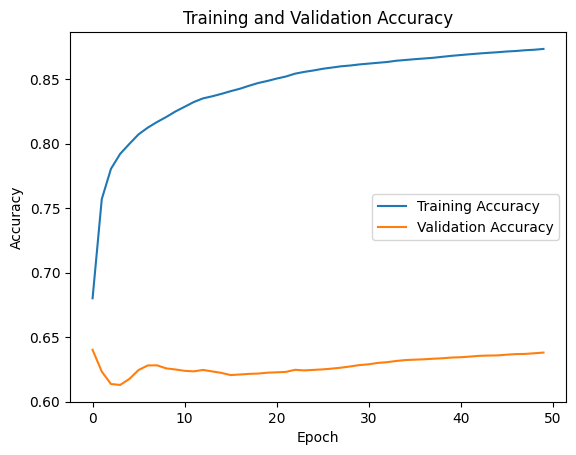

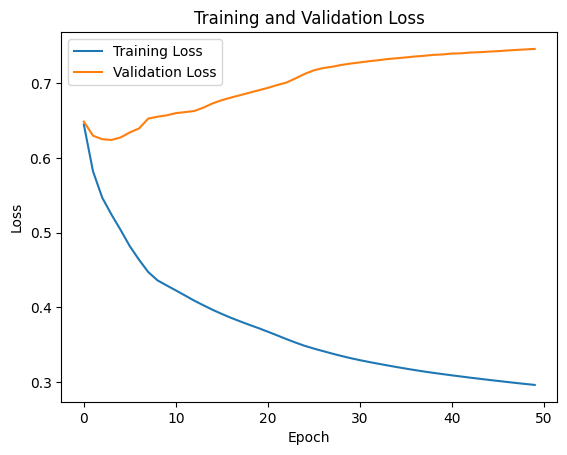

In [40]:
# Obtener métricas de entrenamiento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Accuray -> Train: {train_acc[-1]:.4f} - Val: {val_acc[-1]:.4f}")

# Graficar precisión
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
predictions = sequence_model.predict(validation_ds_batch)
print(predictions.shape)

W0000 00:00:1718748480.909913 1554383 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


7/7 [==============================] - 1s 42ms/step
(3344, 60, 2)


In [31]:
validation_ds

<_TensorSliceDataset element_spec=((TensorSpec(shape=(60, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(60,), dtype=tf.bool, name=None)), TensorSpec(shape=(60, 2), dtype=tf.float32, name=None))>

In [32]:
validation_labels = np.concatenate([labels for train_data, labels in validation_ds])
print(validation_labels.shape)

(200640, 2)


In [33]:
#indices = [i for i, arr in enumerate(validation_labels) if any(subarr[3] == 1 for subarr in arr)]
#validation_labels[indices][0]

In [34]:
#predictions[indices][0]

In [35]:
y_true = np.reshape(validation_labels, (-1, validation_labels.shape[-1]))
y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))

# Eliminar las filas con -1 en y_true
valid_indices = np.where(np.all(y_true != -1, axis=1))
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]
                    
print(y_true.shape)
print(y_pred.shape)

(173147, 2)
(173147, 2)


In [36]:
np.where(y_true == 0)

(array([     0,      1,      2, ..., 173144, 173145, 173146]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [37]:
y_pred[0]

array([0.0232604, 0.9767396], dtype=float32)

In [38]:
binary_pred = (y_pred > 0.5).astype(int)

binary_pred[0]

array([0, 1])

In [39]:
np.unique(binary_pred)

array([0, 1])

In [62]:
# Calcular la precisión
precision = tf.keras.metrics.Precision()
precision.update_state(y_true, binary_pred)
precision_result = precision.result().numpy()

print("Precisión:", precision_result)

Precisión: 0.61775833


In [44]:
# Calcular el recall
recall = tf.keras.metrics.Recall()
recall.update_state(y_true, binary_pred)
recall_result = recall.result().numpy()

print("Recall:", recall_result)

Recall: 0.77382964


In [45]:
# Calcular el F1-score
f1_score = tf.keras.metrics.F1Score()
f1_score.update_state(y_true, binary_pred)
f1_score_result = f1_score.result().numpy()

print(f"F1-score {f1_score_result}")

F1-score [0.7567048]


In [63]:
# Calcular el F1-score
f1_score = tf.keras.metrics.F1Score(average='macro')
f1_score.update_state(y_true, binary_pred)
f1_score_result = f1_score.result().numpy()

print("F1-score:", f1_score_result)

F1-score: 0.57015425


### Calculando con for loop

In [41]:
# Hacer predicciones en los datos de validación en lotes
predictions = []
true_labels = []

for seq_images, labels in validation_ds_batch:
    batch_predictions = sequence_model.predict(seq_images)
    predictions.extend(batch_predictions)
    true_labels.extend(labels)
    
predictions = tf.convert_to_tensor(predictions)
true_labels = tf.convert_to_tensor(true_labels)

16/16 [==============================] - 0s 3ms/step


In [42]:
_y_true = np.reshape(true_labels, (-1, true_labels.shape[-1]))
_y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))

In [43]:
valid_indices = np.where(np.all(_y_true != -1, axis=1))
_y_true = _y_true[valid_indices]
_y_pred = _y_pred[valid_indices]

In [64]:
_y_true

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [65]:
precision_0 = tf.keras.metrics.Precision()
precision_1 = tf.keras.metrics.Precision()
precision_0.update_state(_y_true[[x[0] == 1 for x in _y_true]], _y_pred[[x[0] == 1 for x in _y_true]])
precision_1.update_state(_y_true[[x[1] == 1 for x in _y_true]], _y_pred[[x[1] == 1 for x in _y_true]])
print(f'Precision for class 0: {precision_0.result().numpy():.4f}')
print(f'Precision for class 1: {precision_1.result().numpy():.4f}')

Precision for class 0: 0.4048
Precision for class 1: 0.7515


# Test model

In [ ]:
seq_model = get_sequence_model()
seq_model.load_weights(filepath)

In [ ]:
for train_data, labels in validation_ds.take(1):
    print(train_data[0].shape)
    print(train_data[1].shape)
    print(labels.shape)
    break

In [ ]:
result = seq_model.predict(validation_ds.take(1))

In [ ]:
result.shape

In [ ]:
_, accuracy = seq_model.evaluate(validation_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
seq_model.save('../Modelos/cotatest_rnn.keras')

In [ ]:
new_dataset = tf.data.Dataset.load(f"../datasets/processed/rnn_val_{MAX_SEQ_LENGTH}")
new_dataset